Complete AI Agent orchestration with langgraph

In [363]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

Triage chain

In [364]:
from pydantic import BaseModel, Field
from typing import Literal

class TriageOut(BaseModel):
    decision: Literal["SELF_RESOLVE","REQUEST_INFO","OPEN_TICKET"]
    urgency: Literal["LOW", "MEDIUM", "HIGH"]
    missing_fields: list[str] = Field(default_factory=list)

In [365]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    api_key=GOOGLE_API_KEY
)

In [366]:
triage_Prompt = ("""
                    # Role
                  You are a Service Desk agent responsible for triaging requests related to internal policies at the company "Carraro Desenvolvimento".

                  # Task
                  Given a user's message, you must return ONLY a JSON object with the following structure:
                  {
                    "decision": "SELF_RESOLVE" | "REQUEST_INFO" | "OPEN_TICKET",
                    "urgency": "LOW" | "MEDIUM" | "HIGH",
                    "missing_fields": ["..."]
                  }

                  # Decision Rules
                  - **SELF_RESOLVE**: Use this for clear questions about rules or procedures described in the policies (e.g., "Can I get reimbursed for my home office internet?", "How does the meal policy for work travel function?").
                  - **REQUEST_INFO**: Use this for vague messages that lack the necessary information to identify the topic or context (e.g., "I need help with a policy," "I have a general question.").
                    - When using this decision, you must populate the "missing_fields" array with the specific information that needs clarification (e.g., "policy_name", "problem_description").
                  - **OPEN_TICKET**: Use this for requests that require an exception, release, approval, or special access, or when the user explicitly asks to open a ticket (e.g., "I want an exception to work 5 days remotely," "I am requesting clearance for external attachments," "Please open a ticket with HR for me.").

                  # Urgency Rules
                  - **HIGH**: The user reports an issue that completely prevents them from working, or they mention a security risk, legal issue, or data loss (e.g., "I can't access the system to do my job," "I received a phishing email and clicked the link").
                  - **MEDIUM**: The user has a problem that hinders their work but doesn't block it, or they have an approaching deadline (e.g., "I need approval for a trip next week").
                  - **LOW**: General questions, doubts about policies, or requests that do not have an immediate deadline (e.g., "How does the vacation policy work?", "I have a question about reimbursement").

                  # Final Instruction
                  Analyze the user's message and determine the most appropriate action ("decision") and "urgency" based on the rules defined above.
                  """)

In [367]:
from langchain_core.messages import SystemMessage, HumanMessage

triage_chain = llm.with_structured_output(TriageOut)

def triage(message:str) ->dict:
    output: TriageOut = triage_chain.invoke([
        SystemMessage(content=triage_Prompt),
        HumanMessage(content=message)
    ])
    return output.model_dump()

RAG chain

In [368]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []
data_path = Path('text_docs/')
for d in data_path.glob("*.pdf"):
    try:
        loader = PyMuPDFLoader(str(d))
        docs.extend(loader.load())
        print(f"file loaded succesifuly: {d.name}")
    except Exception as e:
        print(f"failed to load the file {d.name}: {e}")


file loaded succesifuly: Política de Reembolsos (Viagens e Despesas).pdf
file loaded succesifuly: Política de Uso de E-mail e Segurança da Informação.pdf
file loaded succesifuly: Políticas de Home Office.pdf


In [369]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

chunks = splitter.split_documents(docs)

In [370]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

embeddings = GoogleGenerativeAIEmbeddings(
    model = "models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)

In [371]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever(search_type= 'similarity_score_threshold',
                                     search_kwargs = {'score_threshold':0.3,'k':4})

In [372]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert HR and IT assistant for the company 'Torres Devs'. "
               "Your main task is to answer employee questions based ONLY on the context provided. "
               "Be polite and professional in your responses. "
               "If the information to answer the question is not in the provided context, "
               "clearly state that you cannot find the answer in the company's documents."),
    
    ("user", "Based on our company's policies, please answer the following question:\n\nQuestion: {input}\n\nContext:\n{context}")
])

document_chain = create_stuff_documents_chain(llm, rag_prompt)

In [373]:
def ask_question_rag(question:str) -> dict:
    related_docs = retriever.invoke(question)

    if not related_docs:
        return {"answer": "cannot find the answer in the company's documents",
                "citations":[],
                "context_found": False}
    
    answer = document_chain.invoke({"input": question,
                                    "context": related_docs})
    text = (answer or "").strip()

    if text.rstrip(".!?") == "cannot find the answer in the company's documents":
        return {"answer": "cannot find the answer in the company's documents",
                "citations":[],
                "context_found": False}
    return {"answer": text,
            "citations":related_docs,
            "context_found": True}

CODIGO DA AULA

In [374]:
from typing import TypedDict, Optional, List

class AgentState(TypedDict, total = False):
    question: str
    triage: dict
    answer: Optional[str]
    citations: List[dict]
    rag_success: bool
    final_action: str

In [375]:
def triage_node(state: AgentState) -> AgentState:
    print("Executing the triaging node...")
    return {"triage": triage(state["question"])}

In [376]:
def self_resolve_node(state: AgentState) -> AgentState:
    print("Executing the self resolve node...")
    rag_answer = ask_question_rag(state["question"])

    update: AgentState = {"answer": rag_answer["answer"],
                          "citations": rag_answer.get("citations", []),
                          "rag_success": rag_answer["context_found"]}

    if rag_answer["context_found"]:
        update['final_action'] = "SELF_RESOLVE"

    return update

In [377]:
def request_info_node(state: AgentState) -> AgentState:
    print("Executing the ask for info node...")
    missing = state['triage'].get('missing_fields', [])
    detail = ",".join(missing) if missing else "tema e contexto específico"
    return {
        "answer": f"To move forward, I need you to provide this details: {detail}",
        "citations": [],
        "final_action": "REQUEST_INFO"}

In [378]:
def open_ticket_node(state: AgentState) -> AgentState:
    print("Executing the open ticket node...")
    return {
        "answer": f"I'm going to open a ticket for you with urgency {state['triage']['urgency']}. Descrição: {state["question"][:140]}",
        "citations": [],
        "final_action": "OPEN_TICKET"
    }


In [379]:
kw_open_ticket = ["exception","special case","outside of the policy","exceptional cost","approval","approve",
                  "authorization","authorize","manager to approve","budget","quote","release","clearance","unblock",
                  "access","permit","allow","open a ticket","create a ticket","log a request","file a ticket",
                  "formalize this request"]


In [380]:
def manager_triage(state: AgentState) -> str:
    print('deciding after the triage...')
    decision = state["triage"]["decision"]

    if decision == "SELF_RESOLVE": return "self"
    if decision == "REQUEST_INFO": return "request"
    if decision == "OPEN_TICKET": return "open"

In [381]:
def manager_self_resolve(state: AgentState) -> str:
    print('deciding after self resolve...')

    if state.get("rag_success"):
        print("RAG executed with success, ending the program") 
        return "end"
    
    question_state = (state["question"] or "").lower()

    if any(k in question_state for k in kw_open_ticket):
        print("RAG failed but i found a ticket key word. Opening a ticket...")
        return "open"
    
    print("RAG failed, I'm going to ask for more information")
    return "request"

In [382]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("triage", triage_node)
workflow.add_node("self_resolve", self_resolve_node)
workflow.add_node("open_ticket", open_ticket_node)
workflow.add_node("request_info", request_info_node)

workflow.add_edge(START, "triage")
workflow.add_conditional_edges("triage", manager_triage, {
    "self": "self_resolve",
    "request": "request_info",
    "open": "open_ticket"
})
workflow.add_conditional_edges("self_resolve", manager_self_resolve, {
    "request": "request_info",
    "open": "open_ticket",
    "end": END
})

workflow.add_edge("request_info", END)
workflow.add_edge("open_ticket", END)

graph = workflow.compile()

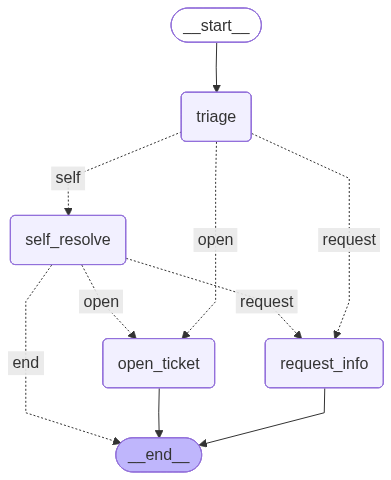

In [383]:
from IPython.display import display, Image

graph_bytes = graph.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [ ]:
test_questions = [
    "How does the reimbursement policy for home office internet expenses work?",
    "I need to know the meal allowance rules for a trip next week; my flight is on Monday.",
    "I received an email that looks like phishing and I clicked the link. What does the security policy say I should do now?",
    "I have a question about a policy.",
    "I would like to request an exception to work 5 days a week remotely next month.",
    "Please open a ticket with HR to formalize my request for a course reimbursement."
]

In [ ]:
for qst in test_questions:
    f_answer = graph.invoke({"question": qst})

    triag = f_answer.get("triage", {})
    print(f"Question: {qst}")
    print(f"Decision: {triag.get('decision')} | Urgency: {triag.get('urgency')} | Final action: {f_answer.get('final_action')}")
    print(f"Answer: {f_answer.get('answer')}")
    print()
    print("------------------------------------")
    print()

Executing the triaging node...
deciding after the triage...
Executing the self resolve node...
deciding after self resolve...
RAG executed with success, ending the program
Question: How does the reimbursement policy for home office internet expenses work?
Decision: SELF_RESOLVE | Urgency: LOW | Final action: SELF_RESOLVE
Answer: Olá!

De acordo com as políticas da Torres Devs, o reembolso para despesas de internet domiciliar para quem trabalha em home office funciona da seguinte forma:

*   Há um subsídio mensal de internet domiciliar.
*   O valor máximo reembolsável é de até R$ 100 por mês.
*   O reembolso é feito mediante a apresentação de uma nota fiscal nominal.

Se precisar de mais detalhes sobre o processo de submissão da nota fiscal, por favor, me informe.
------------------------------------

Executing the triaging node...
deciding after the triage...
Executing the self resolve node...
deciding after self resolve...
RAG executed with success, ending the program
Question: I need